# Neural Networks with PyTorch for Regression (California Housing)

We will compare the performance of our neural network models with a
previously trained RandomForest model that achieved an RMSE of approximately 41,000 dollars.

## Initial Setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

In [ ]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Determine the device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_STATE) # Initialize seed for GPU
else:
    device = torch.device("cpu")
    
print(f"\nUsing device: {device}")


num_workers = os.cpu_count() // 2 # Number of workers. Half of the available cores (common heuristic)


Using device: cpu


## Data Loading

In [ ]:
from utils.load_california import load_housing_data

VAL_SIZE = 0.2

X_train_full, X_test, y_train_full, y_test = load_housing_data()

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

We have separated a validation set. For simplicity, we won't perform *cross-validation* since it is less common in *deep learning* because larger amounts of data are typically used for training, which increases computational cost. However, in this case, the dataset isn't that large and it would be feasible.

## Data Preprocessing

The necessary preprocessing functions defined in the [`utils/housing_preprocessing.py`](utils/housing_preprocessing.py) module are imported. The pipeline must be **fitted** *only* with the **training** data (`X_train`) to avoid information leakage. Then, it is used to **transform** the other sets.

After preprocessing, we will convert the data from NumPy arrays to **PyTorch Tensors**, which are the fundamental data structure in PyTorch.

For the number of clusters in geospatial similarity, we used the value that gave the best results in [the hyperparameter search](e2e081_hyperparameters2.ipynb).

In [ ]:
from utils.housing_preprocessing import get_preprocessing_pipeline

preprocessing_pipeline = get_preprocessing_pipeline(n_clusters=76)

# Fit the pipeline ONLY with training data
preprocessing_pipeline.fit(X_train)

# Apply the pipeline to transform the input data
X_train_processed = preprocessing_pipeline.transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

Feature normalization is essential for neural networks because bringing all attributes to comparable scales prevents those with larger magnitudes from dominating the gradient calculations, which accelerates the convergence of optimization algorithms and improves numerical stability by preventing overflow or "dead" gradients in the flat regions of activation functions. In this case, the preprocessing *pipeline* already standardizes the input variables.

Likewise, normalizing the target variable in regression tasks helps the cost function operate in a reasonable range, facilitates more consistent update steps during learning, and can improve both the convergence speed and the final quality of the model.

In [ ]:
from utils.housing_preprocessing import scale_target
y_train_scaled_np, y_val_scaled_np, y_test_scaled_np, y_scaler = scale_target(y_train, y_val, y_test)

## Defining the Evaluation Metric (and Loss Function)

The evaluation metric (RMSE) was previously defined. Therefore, for neural network models, we will use the `nn.MSELoss()` loss function. Minimizing MSE is equivalent to minimizing RMSE. We will use RMSE to evaluate the model with a more interpretable value.

In [ ]:
criterion = nn.MSELoss() # For neural networks with PyTorch

## Baseline: Random Forest

We start with a Random Forest model using the best hyperparameters found previously; with these, an RMSE of 41,604 USD was achieved using *cross-validation*.

In [ ]:
# %%script false --no-raise-error # To skip a cell during execution

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=290,
    max_depth=87,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=num_workers
)
rf_model.fit(X_train_processed, y_train)
y_val_pred = rf_model.predict(X_val_processed)
val_rmse = root_mean_squared_error(y_val, y_val_pred)

print(f"Random Forest RMSE: {val_rmse:.2f}")

Random Forest RMSE: 44711.24


For the validation set defined in this case, the Random Forest model achieves an RMSE of **44,711 USD. This will be our reference value** for comparison with the neural network models.

## Comparison with Neural Network Models

### Data Preparation

In [ ]:
# Convert NumPy data to PyTorch Tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train_processed.astype(np.float32)).to(device)
X_val_tensor = torch.tensor(X_val_processed.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_processed.astype(np.float32)).to(device)

# Determine the number of input features for the network
n_features = X_train_tensor.shape[1]
print(f"Number of input features: {n_features}")

y_train_tensor = torch.tensor(y_train_scaled_np.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val_scaled_np.astype(np.float32)).to(device)
y_test_tensor = torch.tensor(y_test_scaled_np.astype(np.float32)).to(device)

Number of input features: 90


We use the `TensorDataset` class to create a dataset from the feature and label tensors. Then, we use the `DataLoader` class to create a `DataLoader` from the dataset. The `DataLoader` allows us to iterate over the dataset in *batches*, shuffling the data in each *epoch*.

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 512

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Modelo 1: MLP Simple

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer1 = nn.Linear(n_features, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.output_layer(x)
        return x
    
model1 = SimpleMLP(n_features).to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

Starting detailed training on 'cpu' for 100 epochs...
Epoch [10/100] - 2.44s | Train RMSE: 51525 | Val RMSE: 52077
Epoch [20/100] - 0.84s | Train RMSE: 48371 | Val RMSE: 50505
Epoch [30/100] - 4.78s | Train RMSE: 47230 | Val RMSE: 50913
Epoch [40/100] - 3.47s | Train RMSE: 46594 | Val RMSE: 50648
Epoch [50/100] - 1.32s | Train RMSE: 44276 | Val RMSE: 49826
Epoch [60/100] - 1.66s | Train RMSE: 42748 | Val RMSE: 49343
Epoch [70/100] - 2.71s | Train RMSE: 43733 | Val RMSE: 49981
Epoch [80/100] - 5.29s | Train RMSE: 41152 | Val RMSE: 51070
Epoch [90/100] - 2.35s | Train RMSE: 40035 | Val RMSE: 49839
Epoch [100/100] - 2.68s | Train RMSE: 39335 | Val RMSE: 48903

Detailed training finished in 314.01 seconds.


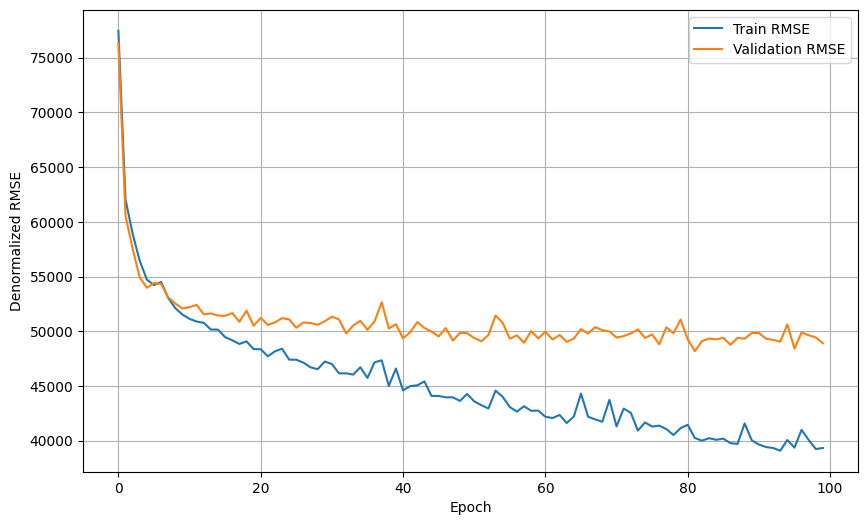

In [ ]:
from utils.training_utils import train_model_detailed, plot_metrics

num_epochs = 100

metrics1 = train_model_detailed(
    model=model1, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    y_scaler=y_scaler, 
    num_epochs=num_epochs, 
    device=device,
    print_every=10 # Print metrics every 10 epochs
)

plot_metrics(metrics1)

## Model 2: Neural Network with Dropout

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(64, 1)  # single‐value regression
        )

    def forward(self, x):
        return self.net(x)
    
model2 = Model2(n_features).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)

Starting detailed training on 'cpu' for 100 epochs...
Epoch [10/100] - 4.21s | Train RMSE: 52403 | Val RMSE: 52078
Epoch [20/100] - 8.61s | Train RMSE: 49583 | Val RMSE: 50166
Epoch [30/100] - 2.61s | Train RMSE: 48278 | Val RMSE: 50122
Epoch [40/100] - 8.92s | Train RMSE: 46731 | Val RMSE: 48886
Epoch [50/100] - 7.10s | Train RMSE: 46260 | Val RMSE: 49196
Epoch [60/100] - 5.91s | Train RMSE: 44517 | Val RMSE: 47698
Epoch [70/100] - 7.62s | Train RMSE: 43847 | Val RMSE: 47340
Epoch [80/100] - 7.07s | Train RMSE: 43320 | Val RMSE: 47264
Epoch [90/100] - 5.73s | Train RMSE: 43185 | Val RMSE: 47985
Epoch [100/100] - 6.04s | Train RMSE: 42428 | Val RMSE: 46773

Detailed training finished in 608.56 seconds.


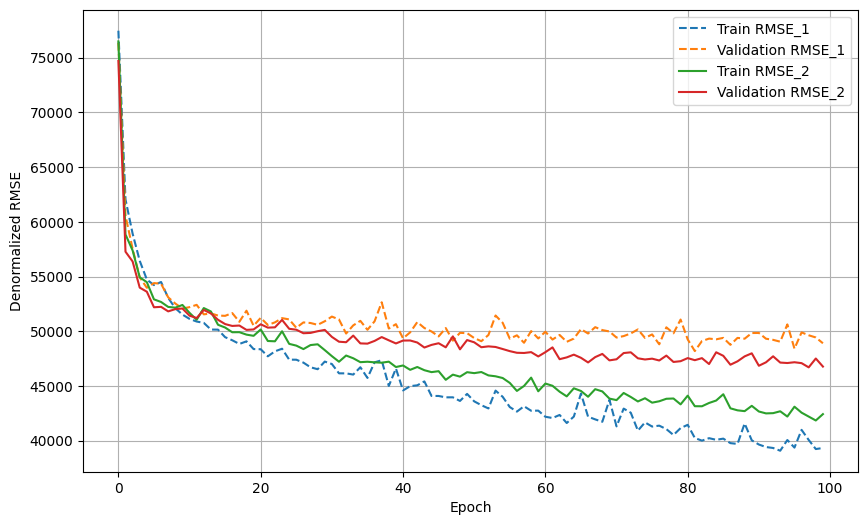

In [ ]:
metrics2 = train_model_detailed(
    model=model2, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    y_scaler=y_scaler, 
    num_epochs=num_epochs, 
    device=device,
    print_every=10 # Print metrics every 10 epochs
)

plot_metrics(metrics1, metrics2)

The new models are observed to not improve upon the reference RMSE.

However, it should be noted that the Random Forest model underwent hyperparameter tuning with *cross-validation*, while the neural network model has not been tuned.